離散時間MPC

In [25]:
import casadi 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [26]:
#定数の定義
a=0.06
b=0.06
c=0.024
d=0.06
e=0.06
f=0.012

K=30

nx=2
nu=1
total=nx*(K+1)+nu*K

Q=casadi.diag([1,1])
Q_f=casadi.diag([1,1])
R=casadi.diag([0.05])

x_lb=[0,0]
x_ub=[np.inf,np.inf]
u_lb=[0]
u_ub=[1]

x_ref=casadi.DM([1,1])
u_ref=casadi.DM([0])

In [27]:
#状態方程式の作成
def make_F():
    states=casadi.SX.sym("states",nx)
    ctrls=casadi.SX.sym("ctrls",nu)

    x=states[0]
    y=states[1]
    u=ctrls[0]

    x_next=(1+a)*x-b*x*y-c*x*u
    y_next=(1-d)*y+e*x*y-f*y*u

    states_next=casadi.vertcat(x_next,y_next)

    F=casadi.Function("F",[states,ctrls],[states_next],
                      ["x","u"],["x_next"])
    
    return F

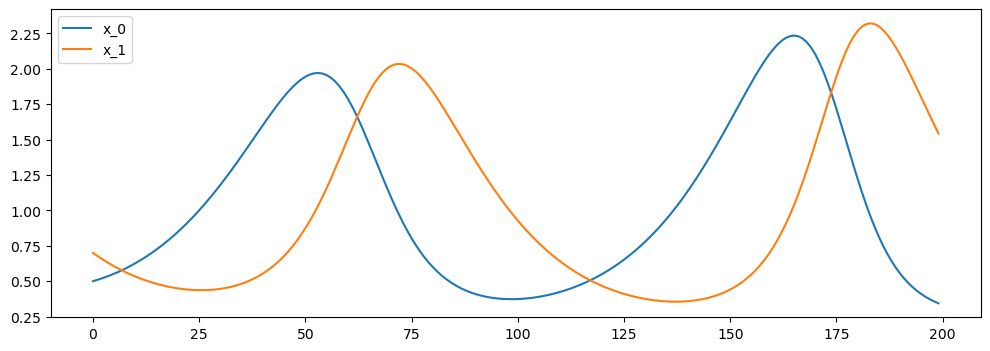

In [28]:
#制御入力0の時の様子
t_span=[0,200]
t_eval=np.arange(*t_span)

x_init=casadi.DM([0.5,0.7])

F=make_F()

X=[x_init]
x_current=x_init
for t in t_eval:
    x_current=F(x=x_current)["x_next"]
    X.append(x_current)

X.pop()
X=np.array(X).reshape(t_eval.size,nx)

plt.figure(figsize=(12,4))

plt.subplot(1,1,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
    plt.legend()

#plt.savefig("image/chap4_mpc_no_control.png")

In [29]:
#評価関数
def compute_stage_cost(x,u):
    x_diff=x-x_ref
    u_diff=u-u_ref
    cost=(casadi.dot(Q@x_diff,x_diff)
          +casadi.dot(R@u_diff,u_diff))/2
    return cost

def compute_terminal_cost(x):
    x_diff=x-x_ref
    cost=casadi.dot(Q_f@x_diff,x_diff)/2
    return cost

In [30]:
#最適化問題の定式化
def make_nlp():
    F=make_F()

    X=[casadi.SX.sym(f"x_{k}",nx) for k in range(K+1)]
    U=[casadi.SX.sym(f"u_{k}",nu) for k in range(K)]
    G=[] #制約条件を格納するリスト

    J=0

    for k in range(K):
        J+=compute_stage_cost(X[k],U[k]) #ステージコスト
        eq=X[k+1]-F(x=X[k],u=U[k])["x_next"] #等式制約を計算してGに加える
        G.append(eq)
    J+=compute_terminal_cost(X[-1]) #終端コスト

    option={"print_time":False,"ipopt":{"print_level":0}}
    nlp={"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    S=casadi.nlpsol("S","ipopt",nlp,option)
    return S

In [31]:
#最適な制御入力を出力する関数の決定
def compute_optimal_control(S,x_init,x0):
    x_init=x_init.full().ravel().tolist()

    lbx=x_init+x_lb*K+u_lb*K
    ubx=x_init+x_ub*K+u_ub*K
    lbg=[0]*nx*K
    ubg=[0]*nx*K

    res =S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)

    offset=nx*(K+1)
    x0=res["x"]
    u_opt=x0[offset:offset+nu]
    return u_opt,x0

In [32]:
#MPCの実行
S=make_nlp()

t_span=[0,200]
t_eval=np.arange(*t_span,1)

x_init=casadi.DM([0.5,0.7])
x0=casadi.DM.zeros(total)

F=make_F()

X=[x_init]
U=[]
x_current=x_init
for t in t_eval:
    u_opt,xo=compute_optimal_control(S,x_current,x0)
    x_current=F(x=x_current,u=u_opt)["x_next"]
    X.append(x_current)
    U.append(u_opt)

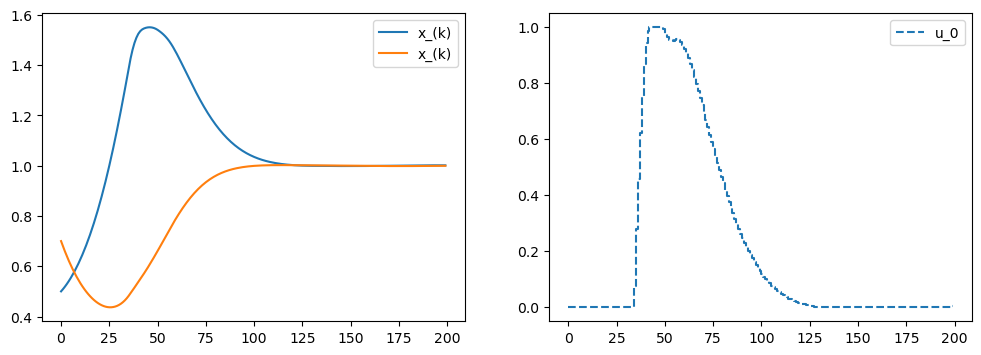

In [33]:
#可視化
X.pop()
X=np.array(X).reshape(t_eval.size,nx)
U=np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_(k)")
plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()

#plt.savefig("image/chap4_mpc.png")
plt.show()

連続時間MPC

In [34]:
# 倒立振子のパラメータ
g = 9.81 #重力加速度
M = 1 #台車の質量
m = 0.2 #振子の質量
l = 1 #振子の長さ

nu = 1 #制御変数の次元
nx = 4 #状態変数の次元

# コスト関数の重み
Q = casadi.diag([2.5,10,0.01,0.01])
Q_f = casadi.diag([2.5,10,0.01,0.01])
R = casadi.diag([0.1])

# 予測ホライズン等
T = 1
K = 20
dt = T/K

# 制約条件
x_lb = [-np.inf,-np.inf,-np.inf,-np.inf]
x_ub = [np.inf,np.inf,np.inf,np.inf]
u_lb = [-15]
u_ub = [15]

# 目標値
x_ref = casadi.DM([0,0,0,0])
u_ref = casadi.DM([0])

total = nx*(K+1) + nu*K #最適化変数の次元

In [35]:
def make_f():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    x = states[0]
    theta = states[1]
    x_dot = states[2]
    theta_dot = states[3]
    F = ctrls[0]

    sin = casadi.sin(theta)
    cos = casadi.cos(theta)
    det = M+m*sin**2

    x_ddot = (-m*l*sin*theta_dot**2+m*g*sin*cos+F)/det
    theta_ddot = (-m*l*sin*cos*theta_dot**2+(M+m)*g*sin+F*cos)/(l*det)

    states_dot = casadi.vertcat(x_dot,theta_dot,x_ddot,theta_ddot)

    f = casadi.Function("f",[states,ctrls],[states_dot],['x','u'],['x_dot'])
    return f

def make_F_RK4():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()

    r1 = f(x=states,u=ctrls)["x_dot"]
    r2 = f(x=states+dt*r1/2,u=ctrls)["x_dot"]
    r3 = f(x=states+dt*r2/2,u=ctrls)["x_dot"]
    r4 = f(x=states+dt*r3,u=ctrls)["x_dot"]

    states_next = states + dt*(r1+2*r2+2*r3+r4)/6

    F_RK4 = casadi.Function("F_RK4",[states,ctrls],[states_next],["x","u"],["x_next"])
    return F_RK4

def make_integrator():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()
    ode = f(x=states, u=ctrls)["x_dot"]

    dae = {"x":states,"p":ctrls,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_stage_cost(x,u):
    x_diff = x - x_ref
    u_diff = u - u_ref
    cost = (casadi.dot(Q@x_diff,x_diff) + casadi.dot(R@u_diff,u_diff)) / 2
    return cost

def compute_terminal_cost(x):
    x_diff = x - x_ref
    cost = casadi.dot(Q_f@x_diff,x_diff) / 2
    return cost

In [36]:
def make_nlp():
    F_RK4 = make_F_RK4()

    U = [casadi.SX.sym(f"u_{k}",nu) for k in range(K)]
    X = [casadi.SX.sym(f"x_{k}",nx) for k in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k],U[k]) * dt
        eq = X[k+1] - F_RK4(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_terminal_cost(X[-1])

    option = {'print_time':False,'ipopt':{'max_iter':10,'print_level':0}}
    nlp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

In [37]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

In [38]:
S = make_nlp()

In [39]:
t_span = [0,10]
t_eval = np.arange(*t_span,dt)

x_init = casadi.DM([0,np.pi,0,0]) # 初期値
x0 = casadi.DM.zeros(total)

I = make_integrator()

X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    u_opt,x0 = compute_optimal_control(S,x_current,x0)
    x_current = I(x0=x_current,p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)

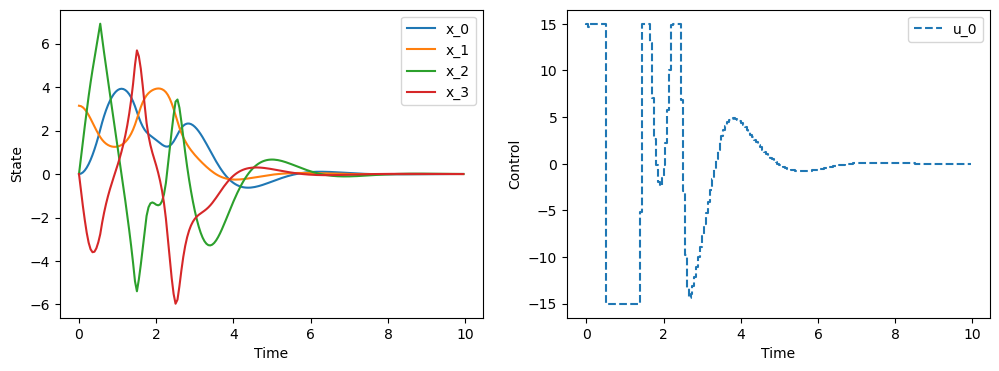

In [40]:
X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("State")

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Control")

#plt.savefig("images/chap5_mpc.png")
plt.show()
